In [1]:
try:
  %tensorflow_version 2.x
except Exception:
    pass


Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [26]:
import tensorflow as tf
from keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dropout,Dense,Lambda
from tensorflow.keras.optimizers import RMSprop
from keras.datasets import fashion_mnist
from keras.utils.vis_utils import plot_model
from keras import backend as K

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFont, ImageDraw
import random

In [4]:
def cift_olustur(x, digit_indices):
  cift = []
  labels = []
  n= min([len(digit_indices[d]) for d in range(10)]) -1 
  for d in range(10):
    for i in range(n):
      z1,z2 = digit_indices[d][i], digit_indices[d][i+1]
      cift += [[x[z1], x[z2]]]
      inc = random.randrange(1,10)
      dn = (d + inc) % 10 
      z1,z2 = digit_indices[d][i], digit_indices[dn][i]
      cift += [[x[z1], x[z2]]]
      labels += [1,0]
  return np.array(cift), np.array(labels)

def ciftlere_etiket_ata(images, labels):
  digit_indices = [np.where(labels==i)[0] for i in range(10)]
  cift,y = cift_olustur(images,digit_indices)
  y = y.astype('float32')
  return cift,y


In [5]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')
train_images = train_images / 255.0
test_images = test_images / 255.0

tr_pairs, tr_y = ciftlere_etiket_ata(train_images, train_labels)
ts_pairs, ts_y = ciftlere_etiket_ata(test_images, test_labels)

4431872/4422102 [==============================] - 0s 0us/step


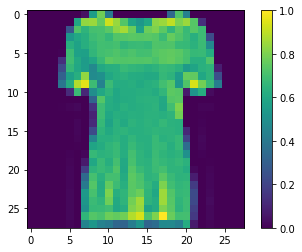

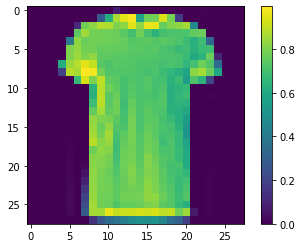

gelen resimler birbiri ile aynı ise 1, değilse 0 etiketini alır.
bu resimlerin etiketi: 1.0


In [6]:
def resim_göster(image):
  plt.figure()
  plt.imshow(image)
  plt.colorbar()
  plt.grid(False)
  plt.show()

this_pair = 6
resim_göster(tr_pairs[this_pair][0])
resim_göster(tr_pairs[this_pair][1])
print("gelen resimler birbiri ile aynı ise 1, değilse 0 etiketini alır.")
print(f"bu resimlerin etiketi: {tr_y[this_pair]}")

In [23]:
def temel_agi_baslat():
  input = Input(shape=(28,28,), name="giris_verileri")
  x = Flatten(name="flatten_girisi")(input)
  x = Dense(128, activation="relu", name="ilk_yogun_katmanimiz")(x)
  x = Dropout(0.1, name="ilk_dropout_katmanimiz")(x)
  x = Dense(128, activation="relu", name="ikinci_yogun_katmanimiz")(x)
  x = Dropout(0.1, name="ikinci_dropout_katmanimiz")(x)
  x = Dense(128, activation="relu", name="ucuncu_yogun_katmanimiz")(x)
  return Model(inputs=input, outputs=x)


def oklid_uzaklıgı(vects):
  x, y = vects
  toplam_kare = K.sum(K.square(x-y), axis=1, keepdims=True)
  return K.sqrt(K.maximum(toplam_kare, K.epsilon()))

def oklid_uzaklıgı_cikis_sekli(shapes):
  shape1, shape2 = shapes
  return (shape1[0], 1)

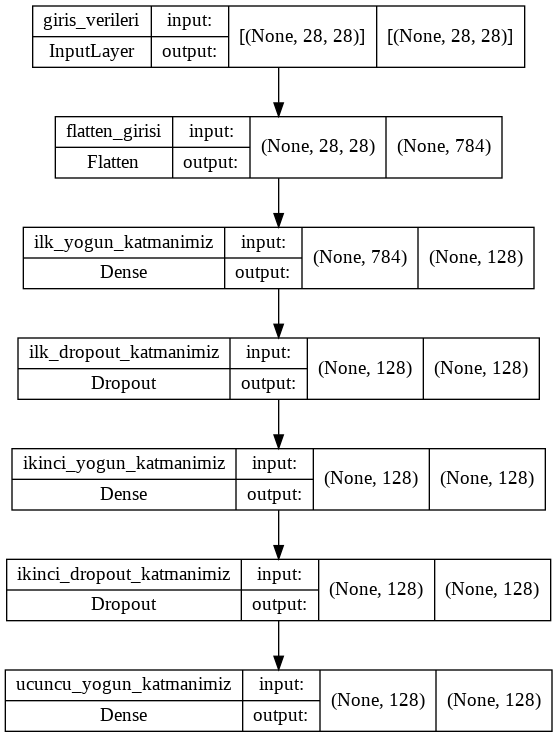

In [25]:
temel_ag = temel_agi_baslat()
plot_model(temel_ag, show_shapes=True, show_layer_names=True, to_file="model-mimarisi.png")

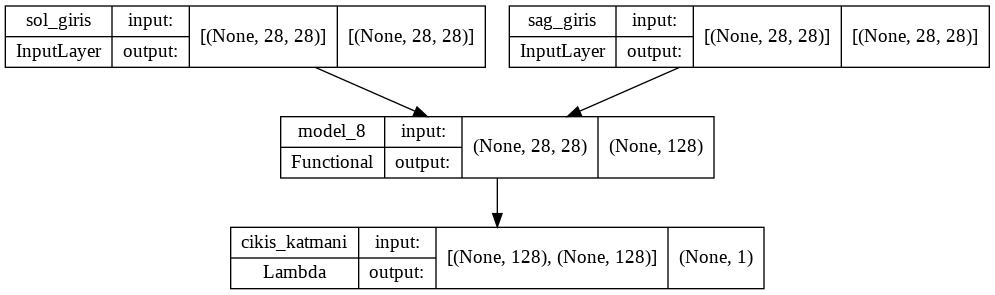

In [27]:
input_a = Input(shape=(28,28,), name="sol_giris")
vect_output_a = temel_ag(input_a)
input_b = Input(shape=(28,28,), name="sag_giris")
vect_output_b = temel_ag(input_b)

output = Lambda(oklid_uzaklıgı, name="cikis_katmani", output_shape = oklid_uzaklıgı_cikis_sekli)([vect_output_a,vect_output_b])
model = Model([input_a, input_b], output)
plot_model(model, show_shapes=True, show_layer_names=True,to_file="siamese-network-mimarisi.png")

In [28]:
def contrastive_loss_with_margin(margin):
  def contrastive_loss(y_true, y_pred):
    squared_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred,0))
    return K.mean(y_true * squared_pred + (1 - y_true) * margin_square)
  return contrastive_loss

In [29]:
rms = RMSprop()
model.compile(loss=contrastive_loss_with_margin(margin=1), optimizer=rms)
history = model.fit([tr_pairs[:,0], tr_pairs[:,1]], tr_y, epochs=20, batch_size=128, validation_data=([ts_pairs[:,0], ts_pairs[:,1]], ts_y))

loss = model.evaluate(x =[ts_pairs[:,0], ts_pairs[:,1]], y = ts_y)

Epoch 1/20
938/938 [==============================] - 10s 9ms/step - loss: 0.1120 - val_loss: 0.0928
Epoch 2/20
938/938 [==============================] - 8s 9ms/step - loss: 0.0797 - val_loss: 0.0742
Epoch 3/20
938/938 [==============================] - 9s 9ms/step - loss: 0.0713 - val_loss: 0.0708
Epoch 4/20
938/938 [==============================] - 8s 9ms/step - loss: 0.0660 - val_loss: 0.0763
Epoch 5/20
938/938 [==============================] - 8s 9ms/step - loss: 0.0632 - val_loss: 0.0664
Epoch 6/20
938/938 [==============================] - 8s 9ms/step - loss: 0.0610 - val_loss: 0.0663
Epoch 7/20
938/938 [==============================] - 8s 8ms/step - loss: 0.0597 - val_loss: 0.0649
Epoch 8/20
938/938 [==============================] - 8s 9ms/step - loss: 0.0582 - val_loss: 0.0632
Epoch 9/20
938/938 [==============================] - 8s 9ms/step - loss: 0.0568 - val_loss: 0.0668
Epoch 10/20
938/938 [==============================] - 8s 9ms/step - loss: 0.0561 - val_loss: 0.063

In [30]:
def dogruluk_hesapla(y_true,y_pred):
  pred = y_pred.ravel() > 0.5
  return np.mean(pred == y_true)

In [31]:
y_pred_train = model.predict([tr_pairs[:,0], tr_pairs[:,1]])
train_accuracy = dogruluk_hesapla(tr_y,y_pred_train)

y_pred_test = model.predict([ts_pairs[:,0], ts_pairs[:,1]])
test_accuracy = dogruluk_hesapla(ts_y, y_pred_test)

print("Loss = {}, Train Accuracy = {} Test Accuracy = {}".format(loss, train_accuracy,test_accuracy))

Loss = 0.06193132326006889, Train Accuracy = 0.06166027671278546 Test Accuracy = 0.08728728728728728


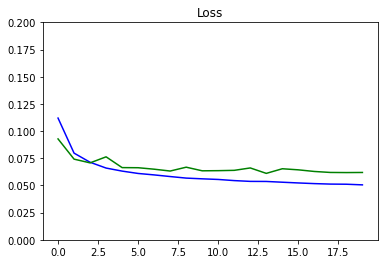

In [32]:
def plot_metrics(metric_name, title, ylim=5):
  plt.title(title)
  plt.ylim(0,ylim)
  plt.plot(history.history[metric_name],color='blue', label=metric_name)
  plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)

plot_metrics(metric_name='loss', title='Loss', ylim=0.2)

In [33]:
def visualize_images():
  plt.rc('iamge', cmap='gray_r')
  plt.rc('grid',linewidth=0)
  plt.rc('xtick', top=False, bottom=False, labelsize='large')
  plt.rc('ytick', left=False, right=False, labelsize='large')
  plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor="white")
  plt.rc('text', color='a8151a')
  plt.rc('figure', facecolor='F0F0F0')

In [42]:
from IPython.core.pylabtools import figsize
def display_images(left, right, predictions, labels,title, n):
  plt.figure(figsize=(17,3))
  plt.title(title)
  plt.yticks([])
  plt.xticks([])
  plt.grid(None)
  left = np.reshape(left, [n,28,28])
  left = np.swapaxes(left, 0, 1)
  left = np.reshape(left, [28,28*n])
  plt.imshow(left)
  plt.figure(figsize(17,3))
  plt.yticks([])
  plt.xticks([28*x+14 for x in range(n)], predictions)
  for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
    if predictions[i] > 0.5: t.set_color('red')
  plt.grid(None)
  right = np.reshape(right, [n,28,28])
  right = np.swapaxes(right, 0, 1)
  right = np.reshape(right,[28,28*n])
  plt.imshow(right)


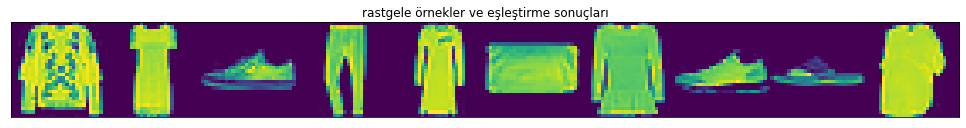

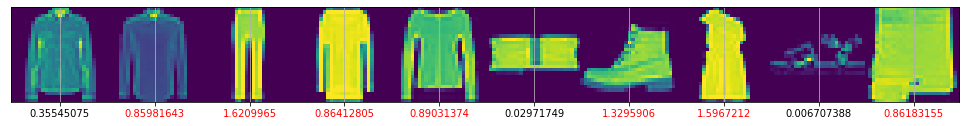

In [55]:
y_pred_train = np.squeeze(y_pred_train)
indexes = np.random.choice(len(y_pred_train), size=10)
display_images(tr_pairs[:,0][indexes], tr_pairs[:,1][indexes], y_pred_train[indexes],tr_y[indexes],"rastgele örnekler ve eşleştirme sonuçları",10)